In [1]:
import cv2
import glob
import imageio
import keras 
import numpy as np
import os
import scipy.io
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

Using TensorFlow backend.


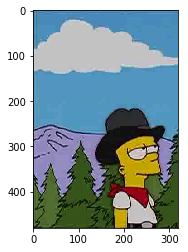

In [7]:
# Plot single image
def plotBart(image_location):
    content_image = imageio.imread(image_location)
    imshow(content_image)
    return

image_location = "./simpsons_dataset_small/train/bart_simpson/pic_0000.jpg"
plotBart(image_location)

In [8]:
# Global varialbes
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Hyperparameters
BATCH_SIZE = 4
NUM_EPOCHS = 1
FC_LAYERS = [1024, 1024, 256, 32] # Fully connected layers
DROPOUT = 0.5 # Dropout rate = 1- keep_prob
LR = 0.0001

In [9]:
def load_train_data():
    train_dir = './simpsons_dataset_large/train' # To change

    train_datagen = ImageDataGenerator(
        rescale=1./255,  
        horizontal_flip=True,
        zoom_range=0.3, 
        rotation_range=30, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2,
        fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                        batch_size=BATCH_SIZE, 
                                                        shuffle = True)
    return train_generator

In [10]:
def load_dev_data():
    dev_dir = './simpsons_dataset_large/dev' # To change

    dev_datagen = ImageDataGenerator(rescale=1./255)
    dev_generator = dev_datagen.flow_from_directory(dev_dir, 
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle = True)
    
    return dev_generator

In [11]:
def load_test_data():
    test_dir = './simpsons_dataset_large/test' # To change

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_dir, 
                                                      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                      batch_size=BATCH_SIZE, 
                                                      shuffle = False)
    
    return test_generator

In [12]:
# Load data
train_generator = load_train_data()
dev_generator = load_dev_data()
test_generator = load_test_data()

label_map = train_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

num_classes = len(label_map)
print (str(label_map))

Found 10816 images belonging to 10 classes.
Found 1999 images belonging to 10 classes.
Found 996 images belonging to 10 classes.
{0: 'bart_simpson', 1: 'charles_montgomery_burns', 2: 'homer_simpson', 3: 'krusty_the_clown', 4: 'lisa_simpson', 5: 'marge_simpson', 6: 'milhouse_van_houten', 7: 'moe_szyslak', 8: 'ned_flanders', 9: 'principal_skinner'}


In [17]:
def build_model(base_model): 
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    
    for fc in FC_LAYERS:
        # New FC layer
        x = Dense(fc, activation='relu')(x) 
        #x = BatchNormalization()(x)
        x = Dropout(rate=DROPOUT)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    model_built = Model(inputs=base_model.input, outputs=predictions)

    return model_built

In [18]:
def build_model_using_VGG16():
    # Change this to use different trained models
    base_model = VGG16(weights='imagenet', 
                       include_top=False, # Won’t be keeping the Fully-Connected (FC) layers at the end of the mode
                       input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    model = build_model(base_model)
    model.summary()
    return model

In [24]:
model = build_model_using_VGG16()

#Compile model
opt = Adam(lr=LR, decay=0.000001)
#opt = SGD(lr=LR)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

# model = load_model("./model.h5")
# print(K.get_value(model.optimizer.lr))
# # To set learning rate
# K.set_value(model.optimizer.lr, 0.00001)
# print(K.get_value(model.optimizer.lr))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [21]:
# Plot the training and dev loss & accuracy
def plot_training_and_dev(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'rs')
    plt.plot(epochs, val_acc, 'g^')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'rs')
    plt.plot(epochs, val_loss, 'g^')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

In [22]:
def show_predictions(predictions):
    labels = [label_map[i] for i in range(len(label_map))]
    y_true = [label_map[i] for i in test_generator.classes]
    y_pred = [label_map[i] for i in predictions]
    
    report = classification_report(y_true, y_pred, labels=labels)
    print (str(report))

    cm = confusion_matrix(y_true, y_pred, labels)
    
    #print(cm)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    #plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [23]:
def run_model():
    # Checkpoints
    checkpoint_filepath = "./model.h5"
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # Train model using train and dev data
    history = model.fit_generator(train_generator, 
                                  steps_per_epoch=train_generator.n // train_generator.batch_size, 
                                  validation_data=dev_generator, 
                                  validation_steps=dev_generator.n // dev_generator.batch_size, 
                                  epochs=NUM_EPOCHS, 
                                  workers=100, 
                                  shuffle=True,
                                  callbacks=callbacks_list)

    # Plot training and dev: loss and accuracy
    plot_training_and_dev(history)
    
    # Predict test data
    predictions = model.predict_generator(test_generator, 
                                          steps = test_generator.n // test_generator.batch_size)
    predictions = np.argmax(predictions, axis=-1) #multiple categories     
    show_predictions(predictions)

In [ ]:
run_model()